# Organizing, Subsetting and Processing Data

Now that you've successfully downloaded the GRACE and GLDAS data, you will need to read in and process the data to get groundwater anamoly estimates. Both datasets have raw data contained in .nc or .nc4 files. These are files for storing multi-dimensional data--in our case, the key dimensions we are interested in are latittude and longitude (geography) and time. We can use the `xarray` package to read in these data. 

## Reading in GRACE and GLDAS Data

Both datasets have similar processes for loading in the data which are outlined in detail below. However, the first step for processing both datasets is to filter to your region of interest. This is important because it makes processing times for each step much quicker. As such, our first step in processing will be loading in a shapefile and filtering to the region of interest before loading in GRACE and GLDAS and merging them with other datasets. 

### Subsetting The Data 

For most use cases, it will make the most sense to load in a shapefile and use this file to narrow down your region. This will allow your analysis to focus on your area of interest as precisely as possible and improve the efficiency of your code. If you don't have a shapefile or know your region of interest, you can pick any 4 latitude/longitude points and use them to draw a rectangle around a region of the world you are interested in. You can also skip this step, but note it will make the code take much longer to run. 

For our analysis here, we will use a shapefile that focuses on the Colorado River Basin. 

#### What is a Shapefile? 

A shapefile is a file that stores geometric location and attribute information of geographical features in a nontopological way. Shapefiles represent geographical features by points, lines, or polygons (geographical areas) (ArcGIS). It is one of the simpler ways to store and work with geographic data. Many shapefiles are publicly available for download by government agencies, researchers, or practitioners. Below is an example of what a shapefile looks like in tabular form and how you can go from that to a map.

<img src='images/shape%20file%20figure.png'>
Source: ReStore

#### Applying This Method to the CRB 

Below, we use this method to use a shapefile of the Colorado River Basin for analysis. You can download the shape file for the Colorado River Basin from ArcGIS hub [here](https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/colorado-river-basin-hydrological-boundaries-with-areas-served-by-colorado-river/explore?location=36.244092%2C-110.573590%2C6.00). A visual of this is shown below: 

<img src='images/CRB_shapefile.png'>

To work with shapefiles, we will use the `geopandas` package, a spatial analysis package built on top of `pandas`. We will begin by loading in this package and reading in the shapefile. Next, we will load in plotting functions from `matplotlib` and map the shapefile. 

In [ ]:
# import necessary packages and libraries 
import geopandas as gpd 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as pd 
import xarray as xr
import os 
from datetime import datetime


<Figure size 1000x1000 with 0 Axes>

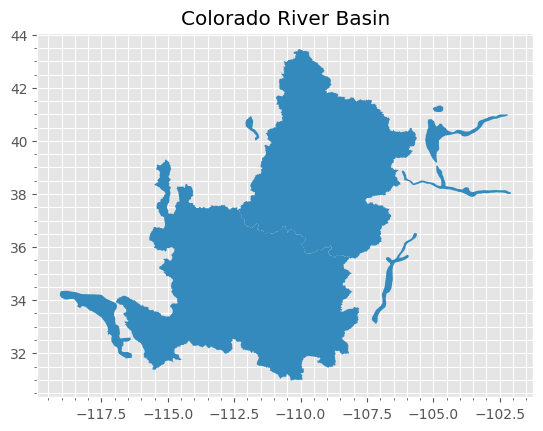

In [1]:
basin_shapefile = gpd.read_file("data/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")

# Plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
basin_shapefile.plot()
plt.title("Colorado River Basin")
plt.grid(which="minor")
plt.minorticks_on()
plt.show()

A simple way to start narrowing down to the area within the Colorado River Basin is to construct a rectangle around the region and only read in and process rows within that rectangle: 

<p align="left">
    <img src="images/CRB%20rectangle.jpg" width="600" />
</p>

As you can see from the image above, a substantial amount of geography that is not within the CRB is still in the rectange. We will use spatial processes to eliminate those from our dataset later in the process. For now though, focusing on this rectangle will greatly speed up reading and applying other transformations to the data. 

The code to do this is provided below. 

In [2]:
# Code to filter to shapefile

# extract a dataframe of the coordinates from the shapefile
coords = basin_shapefile.get_coordinates()
# find the maximum and minimum lat/longs, corresponding to the red points on the figure above
lon_min = min(coords['x'])
lon_max = max(coords['x'])
lat_min = min(coords['y'])
lat_max = max(coords['y'])

### GRACE

The GRACE MASCON data is contained in 1 .nc file and contains global land MASCON GRACE data. We start by using `xarray` to read in the data. 

In [4]:
# Need to change this to relative path later
grace = xr.open_dataset("data/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc") 

# print out grace data. Note our interest variable lwe_thickness is measured in centimeters 
grace

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 220, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2023-04-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 ...
    mascon_ID      (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2023-06-28T21:06:45Z

The first thing you will note is that the dataset has several dimensions: `lon`, `lat`, `time`, and `bounds`. This is because the GRACE data come at the pixel-level for each year. In our sitution, a pixel is the smallest geographic unit of analysis. Because collecting and processing GRACE satellite data is technical and compuationally expensive, GRACE measurements are given as .5-degree by .5-degree squares. The pixels cover the entire Earth's surface and each have a GRACE measurement monthly from 2002-present. A visual of this is shown below, where each square in the GRID correponds to a pixel (Sharma, Patnaik, Biswal, Reager, 2020). Note that the yellow dots are gauging stations for comparison. 

<p align="center">
    <img src="images/GRACE_grids.png" width="500" />
</p>

First, since the data is an xarray dataset, we can do some processing to transform the dataset into a standard tabular, pandas dataframe. For efficiency, we can also only select the variables we need, and for use with other datasets, we will transform the longitude points from a [0,360] range to a [-180,180] range.  

An **important** point to note is that when we change our data into a tabular format, each latitude and longitude combination will be the center of a pixel and will uniquely identify each pixel. Thus, it is important to understand that the associated value is not representative of this exact point but rather the entire pixel that the point is a center of. Though not necessary for our analysis, if you wanted to get the coordinates of each of the four corners, you would just have to add and subtract the pixel length divided by 2 to each latitude and longitude value. 

In [34]:
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon

In [35]:
# transforming to dataframe and selecting relevant vars
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df.reset_index(inplace=True)
grace_df.reset_index(drop=True)
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})

# dropping duplicates, since there will be a duplicate for each lat/lon combo because of the bounds 
grace_df = grace_df.drop_duplicates()

#subsetting to rectangle containing the Colorado River Basin
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)

grace_df = grace_df[(grace_df.lon> lon_min) & (grace_df.lon < lon_max)]
grace_df = grace_df[(grace_df.lat> lat_min) & (grace_df.lat < lat_max)]


In [36]:
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor
38227640,-118.75,31.25,2002-04-17 12:00:00,-0.378444,3.706507,NaN
38227641,-118.75,31.25,2002-05-10 12:00:00,-1.042155,1.875190,NaN
38227642,-118.75,31.25,2002-08-16 12:00:00,2.235313,1.735942,NaN
38227643,-118.75,31.25,2002-09-16 00:00:00,0.690407,1.760610,NaN
38227644,-118.75,31.25,2002-10-16 12:00:00,0.096125,1.564023,NaN
...,...,...,...,...,...,...
40846735,-102.25,43.25,2022-12-16 12:00:00,2.922378,2.210404,1.158091
40846736,-102.25,43.25,2023-01-16 12:00:00,7.670940,2.844838,1.158091
40846737,-102.25,43.25,2023-02-15 00:00:00,9.175151,3.539803,1.158091
40846738,-102.25,43.25,2023-03-16 12:00:00,11.816389,4.226812,1.158091


The last step in processing GRACE data is to multiply lwe_thickness at each pixel by a scale factor and convert the units. The scale factors are intended to restore much of the energy that is removed due the sampling and post-processing of GRACE observations. More information about the scaling factors can be found [here](https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/). Moreover, please note that NASA states users should multiply the data by the scaling coefficient, so it is imperative not to skip this step. 

The original terrestrial water storage is measured in centimeters, we convert the unit to kimoleter cubed by:
1. convert the terrestrial water storage to kilometer
2. multiplying each data point by the surface area of each pixel measured in kilometer squared to get terrestrial water storage in kilometer cubed

In the following code, we also converted the unit of uncertainty for your convenience in case you want to incorporate uncertainty in your calculation. More information on how to incorporate uncertainty is documented in the Understanding Uncertainty file.
Note: the scale factor does not have a unit nor change with time, so no handling of it needs to be attended to

In [7]:
grace_df.sort_values(by='time', inplace=True)

# Compute surface area for pixel with dimension 0.5 x 0.5 degree. Note the area of pixel changes with latitude. 6,371 is Earth's radius in kilometer
EARTH_RADIUS_KM = 6371
grace_df['surface_area_km2_0.5'] = EARTH_RADIUS_KM * np.radians(.5) * EARTH_RADIUS_KM * np.radians(.5) * np.cos(np.radians(grace_df['lat']))

# Converting units from cm to km3
CM_TO_KM_RATIO = 1e-5
grace_df["lwe_thickness_km3"] = grace_df["lwe_thickness_cm"] * grace_df['scale_factor'] * CM_TO_KM_RATIO * grace_df['surface_area_km2_0.5']
grace_df['uncertainty_km3'] = grace_df["uncertainty_cm"] * CM_TO_KM_RATIO * grace_df['surface_area_km2_0.5']
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor,surface_area_km2_0.5,lwe_thickness_km3,uncertainty_km3
9715640,-118.75,31.25,2002-04-17 12:00:00,1.135869,2.638984,1.603936,2642.599214,0.048144,0.069738
11458480,-107.75,32.25,2002-04-17 12:00:00,7.364322,14.865509,0.509262,2614.210603,0.098043,0.388616
11458700,-107.75,32.75,2002-04-17 12:00:00,7.364322,14.865509,0.509262,2599.717129,0.097499,0.386461
11458920,-107.75,33.25,2002-04-17 12:00:00,7.364322,14.865509,0.682281,2585.025678,0.129886,0.384277
11459140,-107.75,33.75,2002-04-17 12:00:00,7.364322,14.865509,0.682281,2570.137366,0.129138,0.382064
...,...,...,...,...,...,...,...,...,...
11460019,-107.75,35.25,2023-04-16 00:00:00,-6.318313,8.447631,1.251672,2524.302686,-0.199633,0.213244
11459799,-107.75,34.75,2023-04-16 00:00:00,-6.318313,8.447631,0.990343,2539.774714,-0.158921,0.214551
11459579,-107.75,34.25,2023-04-16 00:00:00,-21.944085,6.949303,1.469034,2555.053329,-0.823662,0.177558
11538559,-107.25,33.75,2023-04-16 00:00:00,-21.944085,6.949303,0.682281,2570.137366,-0.384802,0.178607


### GLDAS Data 

Next, we will read in the GLDAS data which provides us with information on snow pack and soil moisture. These data are similarly in a multidimensional data format which can be read in using `xarray`. However, the data come in individual files that require being read in and combined into one dataset. The code below does this. 

In [8]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset("/data/GLDAS/NOAH_monthly_L4/GLDAS_NOAH025_M.A200001.021.nc4")

<xarray.Dataset>
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01
  * lon                    (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * lat                    (lat) float32 -59.88 -59.62 -59.38 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] ...
    Swnet_tavg             (time, lat, lon) float32 ...
    Lwnet_tavg             (time, lat, lon) float32 ...
    Qle_tavg               (time, lat, lon) float32 ...
    Qh_tavg                (time, lat, lon) float32 ...
    Qg_tavg                (time, lat, lon) float32 ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 ...
    Tair_f_inst            (time, lat, lon) float32 ...
    Qair_f_inst            (time, lat, lon) float32 ...
    Psurf_f_inst           (time, lat, lon) float32 ...
    SWdown_f_tavg          (time, lat, lon) float32 ...
    LWdown_f_tavg          (time, lat, lon) float32 ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [63]:
### import GLDAS data, filter to CRB, combine into one dataframe 

gldas_path = "data/GLDAS/NOAH_monthly_L4/"

gldas_df = pd.DataFrame()

#Iterating through files in path
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gldas_path+str(filename))
        xd_df = xd.to_dataframe()

        xd_df.reset_index(inplace=True)

        xd_df = xd_df[(xd_df.lon> lon_min) & (xd_df.lon < lon_max)]
        xd_df = xd_df[(xd_df.lat> lat_min) & (xd_df.lat < lat_max)]

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "RootMoist_inst"]]
        df_slice = df_slice.drop_duplicates()

        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

gldas_df = gldas_df.rename(columns={'SWE_inst': 'SWE_inst_kg/m2', 'RootMoist_inst': 'RootMoist_inst_kg/m2'})

In the following code, we are changing the units of Soil Moisture and Snow Water Equivalent to kilometer cubed. The two variables are originally measured in kg/m2.

We convert the unit to kimoleter cubed by:
1. multiply each data point by 1,000,000 to convert the data point in kg/km2
2. multiply each data point by the surface area of each pixel measured in kilometer squared to get the two variables measured in kilograms
3. At standard temperature and pressure, water has density of 1 kg/Liter. So 1 kg water = 1 Liter = 1e-12 kilometer cubed. We multiply the data by (1e-12) to get the data in kilometer cubed

In [65]:
# Compute surface area for pixel with dimension 0.25 x 0.25 degree. 
gldas_df['surface_area_km2_0.25'] = EARTH_RADIUS_KM * np.radians(.25) * EARTH_RADIUS_KM * np.radians(.25) * np.cos(np.radians(gldas_df['lat']))

# Converting units from kg/m2 to km3
KG_PER_M2_TO_KG_PER_KM2_RATIO = 1e6
KG_TO_KM3_RATIO = 1e-12


gldas_df['RootMoist_inst_km3'] = gldas_df['RootMoist_inst_kg/m2'] * KG_PER_M2_TO_KG_PER_KM2_RATIO * gldas_df['surface_area_km2_0.25'] * KG_TO_KM3_RATIO
gldas_df['SWE_inst_km3'] = gldas_df['SWE_inst_kg/m2'] * KG_PER_M2_TO_KG_PER_KM2_RATIO * gldas_df['surface_area_km2_0.25'] * KG_TO_KM3_RATIO
gldas_df

,time,lon,lat,SWE_inst_kg/m2,RootMoist_inst_kg/m2,surface_area_km2_0.25,RootMoist_inst_km3,SWE_inst_km3
146764,2017-10-01,-118.875,31.125,NaN,NaN,661.522827,NaN,NaN
146765,2017-10-01,-118.875,31.375,NaN,NaN,659.773621,NaN,NaN
146766,2017-10-01,-118.875,31.625,NaN,NaN,658.011841,NaN,NaN
146767,2017-10-01,-118.875,31.875,NaN,NaN,656.237488,NaN,NaN
146768,2017-10-01,-118.875,32.125,NaN,NaN,654.450745,NaN,NaN
...,...,...,...,...,...,...,...,...
187009,2000-01-01,-102.125,42.375,0.668583,72.323608,570.883057,0.041288,0.000382
187010,2000-01-01,-102.125,42.625,0.551255,71.502670,568.605042,0.040657,0.000313
187011,2000-01-01,-102.125,42.875,0.551538,64.827583,566.316284,0.036713,0.000312
187012,2000-01-01,-102.125,43.125,0.763360,169.107285,564.016724,0.095379,0.000431


### Focusing on the Basin 

Returning to the GRACE data, we saw earlier that though the data is filtered down to a rectangle containing the Colorado River Basin, there are still areas that are not contained in the rectangle. We can use geoprocessing techniques from `geopandas` to keep points in GRACE that only intersect the shape file. 

In [21]:
# Create a GeoDataFrame directly from grace_df
grace_gdf = gpd.GeoDataFrame(grace_df, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat']))

# Ensure the CRS for basin_shapefile is set correctly
basin_shapefile.crs = "EPSG:4326"

# Use sjoin to find points that intersect with the shapefile
intersected = gpd.sjoin(grace_gdf, basin_shapefile, how="inner", predicate="intersects")

# Select the columns we are interested in
grace_df = intersected[['lon', 'lat', 'time', 'lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'surface_area_km2_0.5','lwe_thickness_km3', 'uncertainty_km3']]

##### Upsampling GRACE

One key consideration for combining GRACE and GLDAS data is that pixels in GRACE data are .5°x.5° while GLDAS data has .25°x.25° pixels. One way to handle this without loss of data is to "upscale" GRACE data to make it mergable with GLDAS. That is, transform the GRACE data pixels from .5°x.5° to .25°x.25°. That is, we transform the GRACE data pixels from a granularity of .5°x.5° to one of .25°x.25°. This process yields a four points for each original point.

One way we can do this is to "upsample" GRACE data. This is shown visually below: 

<p align="center">
    <img src="images/upscale.png" width="500" />
</p>

After upsampling, you are left witha final product of evenly-spaced, non-overlapping $.25°x.25°$ pixels (shown below, far right panel). 

<p align="center">
    <img src="images/crb_upscale.png" width="1200" />
</p>

Each "pixel" thus represents a chunk of land approximately 235.46 miles squared ($\approx$ 378.94 kilometers squared). A visualization of an individual pixel is shown below.

<p align="center">
    <img src="images/lon-lat.png" width="500" />
</p>

In [43]:
# Helper function to generate the upsampled GRACE data
def upsample_point(row):
    # For the row of GRACE dataframe inputted in the function, we first store the time, lon, lat, lwe_thickness, and uncertainty value
    t = row['time']
    x = row['lon']
    y = row['lat']
    lwe = row['lwe_thickness_km3']
    uncertainty = row['uncertainty_km3']
    
    # Create upscaled longitude values (by creating a distance of 0.125 on each side of the
    # original longitude (x), you obtain a total length of 0.25 around each original point)
    xx = [round(x-0.125,3), round(x+0.125,3)]

    # Create upscaled latitude values (by creating a distance of 0.125 on each side of the
    # 0riginal latitude (y), you obtain a total length of 0.25 around each original point)
    yy = [round(y-0.125,3), round(y+0.125,3)]
    
    # Returning a list of upsampled points for the row inputted, notice the lwe_thickness and the uncertainty value stay the same
    return [
        {"time": t, "lon": xx[0], "lat": yy[0], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[0], "lat": yy[1], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[1], "lat": yy[0], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[1], "lat": yy[1], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty}
    ]

# Loop over each row in the GRACE dataframe and perform the helper function to generate a list of upsampled points
upsampled_points = [record for _, row in grace_df.iterrows() for record in upsample_point(row)]

# Convert the list of upsampled points into a DataFrame
upsampled_grace_df = pd.DataFrame(upsampled_points)


#### Edge Pixels

The edges of the basin often do not completely intersect with a pixel. For example, in the figure below, each square on the graph is a 5°x.5° square. As you can see, within the center of the basin, there is perfect overlap between several pixels and the basin. However, when you get to the outer edges of the basin, you can see that there is not perfect overlap with a pixel. The basin only covers part of a pixel around the edges. 

For our analysis, we only include a pixel in calculating groundwater anamolies if the center of the pixel is contained within the basin. This will generally include pixels that have a majority of their area within the basin and exclude pixels that do not. Additionally, since the Colorado River Basin is so large, the effect of edge cases on our calculations will be small. However, if you plan to analyze the region within a smaller basin, one strategy to account for this is to use an area weighting average of the pixel with the basin. This will allow you to weight your values by the area that intersects both the pixel and the basin. 

<Figure size 1000x1000 with 0 Axes>

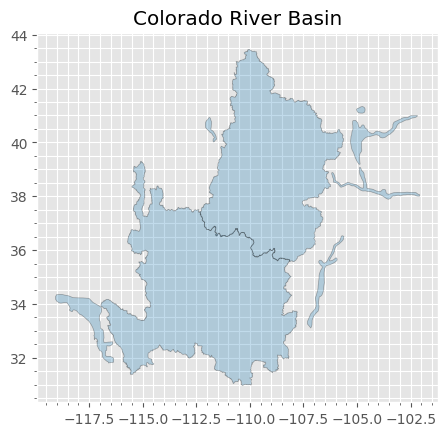

In [45]:
# Plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
basin_shapefile.plot(alpha=.3, edgecolors='black')
plt.title("Colorado River Basin")
plt.grid(which="minor")
plt.minorticks_on()
plt.show()

### Merging the Datasets 

Now that GRACE and GLDAS are in standardized, tabular formats, we can merge these datasets together to combine all the variables of interest and calculate groundwater estimates. Note that since the GRACE data is already filtered to the area of interest, we can simply perform a left join to merge GLDAS with GRACE data. 

In [66]:
# Standardize times in both datasets and do a left join 
upsampled_grace_df['time'] = pd.to_datetime(upsampled_grace_df["time"].astype(str).str.slice(0, 7), format='%Y-%m')
gldas_df['time'] = pd.to_datetime(gldas_df["time"].astype(str).str.slice(0, 7), format='%Y-%m')

grace_gldas_df = upsampled_grace_df.merge(gldas_df, on=["time", "lat", "lon"], how="left")

### Calculating Anamolies 

In order to compute groundwater anamolies, you need to compute the deviation from the mean for each measurement:

$$d_i = p_i - \mu$$

where ($d_i$) is the deviation from the mean for obervation i, ($p_i$) is the measurement for observation i, and $\mu$ is the average over the specified time period. 

In order to calculate $\mu$, you take the average for each water category over a specified time period. Here, we use the time period from 2004-2009, following NASA and recent literature, which is shown in code below. Note that the code is easily modifiable if you would like to focus on a different time period. 


In [62]:
grace_gldas_df

,time,lon,lat,lwe_thickness_km3,uncertainty_km3,SWE_inst_kg/m2,RootMoist_inst_kg/m2,surface_area_km2_0.25,RootMoist_inst_km3,SWE_inst_km3,SWE_mean_km3,RootMoist_mean_km3,SWE_anomaly_km3,RM_anomaly_km3
0,2002-04-01,-107.875,36.125,0.022028,0.326457,0.000125,198.631012,624.191162,0.123984,7.802390e-08,4.179474e-04,0.142087,-0.000418,-0.018104
1,2002-04-01,-107.875,36.375,0.022028,0.326457,0.000417,185.748169,622.197388,0.115572,2.592489e-07,7.095727e-04,0.134651,-0.000709,-0.019079
2,2002-04-01,-107.625,36.125,0.022028,0.326457,0.000792,192.276886,624.191162,0.120018,4.941513e-07,6.061216e-04,0.139958,-0.000606,-0.019941
3,2002-04-01,-107.625,36.375,0.022028,0.326457,0.000958,191.645065,622.197388,0.119241,5.962725e-07,7.958029e-04,0.140339,-0.000795,-0.021098
4,2002-04-01,-107.875,36.625,0.021886,0.324355,0.000500,135.449722,620.191711,0.084005,3.100959e-07,4.510001e-04,0.102068,-0.000451,-0.018063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254315,2023-04-01,-116.625,32.375,-0.223049,0.088856,NaN,NaN,NaN,NaN,NaN,1.537655e-09,0.086928,NaN,NaN
254316,2023-04-01,-118.875,34.125,-0.224568,0.086845,NaN,NaN,NaN,NaN,NaN,1.074783e-09,0.099957,NaN,NaN
254317,2023-04-01,-118.875,34.375,-0.224568,0.086845,NaN,NaN,NaN,NaN,NaN,5.253188e-08,0.102676,NaN,NaN
254318,2023-04-01,-118.625,34.125,-0.224568,0.086845,NaN,NaN,NaN,NaN,NaN,4.311073e-09,0.068815,NaN,NaN


In [ ]:
# Filter the dataframe to include only the required dates
mask = (grace_gldas_df['time'] >= '2004-01-01') & (grace_gldas_df['time'] <= '2013-12-31')
filtered_df = grace_gldas_df.loc[mask]

# Group by lat and lon and calculate average storage for the specified date range
average_df = filtered_df.groupby(['lat','lon']).agg({'SWE_inst_km3':'mean', 'RootMoist_inst_km3':'mean'}).reset_index()
average_df = average_df.rename(columns={'SWE_inst_km3':'SWE_mean_km3', 'RootMoist_inst_km3':'RootMoist_mean_km3'})

grace_gldas_df = grace_gldas_df.merge(average_df, on=['lat','lon'], how='left')

# Compute the anomaly for soil moisture and snow water equivalent
grace_gldas_df['SWE_anomaly_km3'] = grace_gldas_df['SWE_inst_km3'] - grace_gldas_df['SWE_mean_km3']
grace_gldas_df['RM_anomaly_km3'] = grace_gldas_df['RootMoist_inst_km3'] - grace_gldas_df['RootMoist_mean_km3']